In [4]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
# This is needed to display the images.
%matplotlib inline
# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("/Users/robertsonwang/Desktop/Python/test_strips/object_detection/")
from utils import label_map_util
from utils import visualization_utils as vis_util

In [13]:
# What model to download.
MODEL_PATH = 
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_PATH + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/Users/robertsonwang/Desktop/Python/test_strips/data/', 'ts_labels_train.txt')

NUM_CLASSES = 90

In [10]:
#Load graph into memory
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [15]:
#Load labels and categories
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [16]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

In [30]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/Users/robertsonwang/Desktop/models/research/object_detection/test_images2/'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 8) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

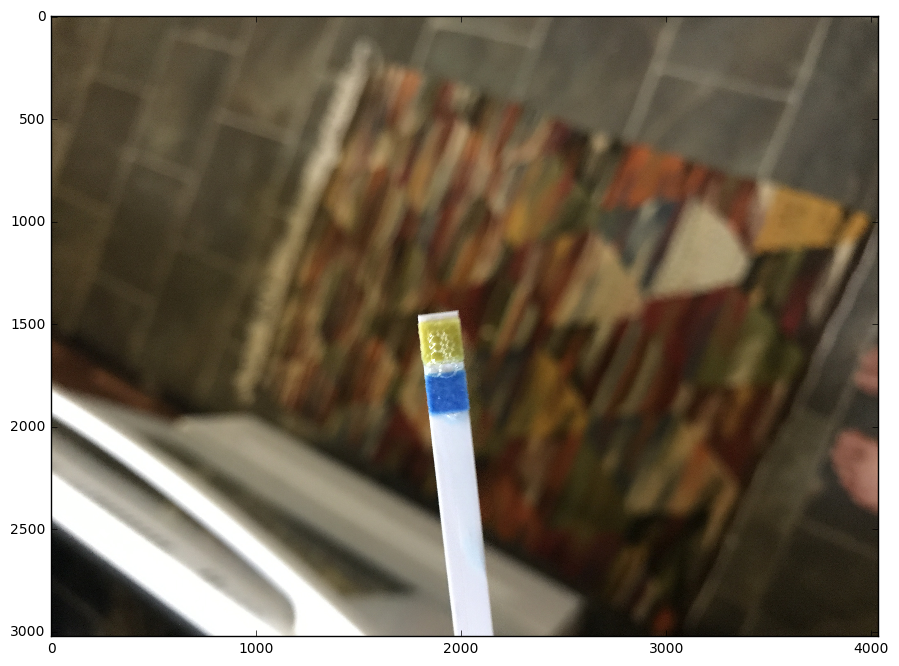

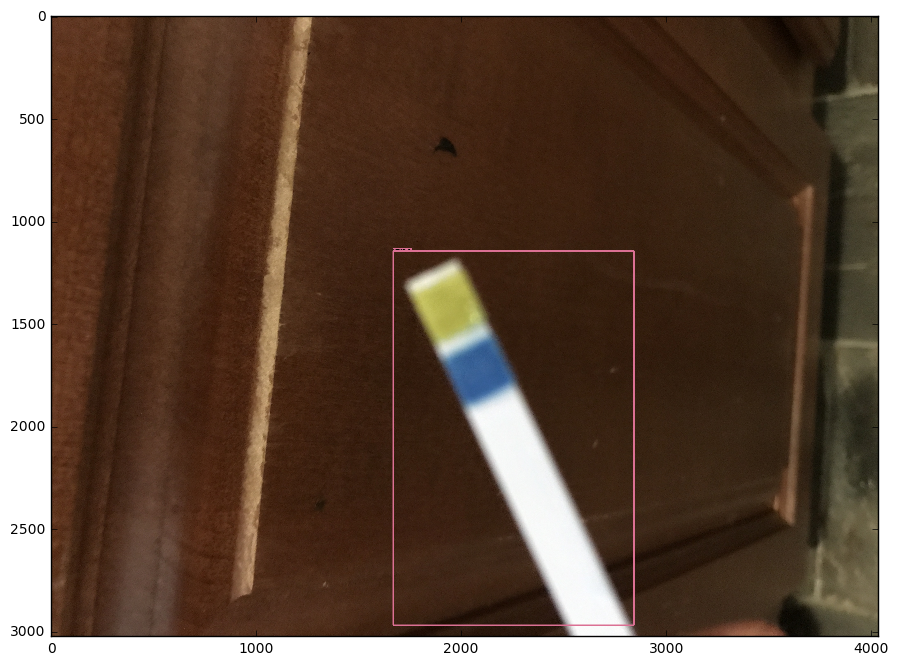

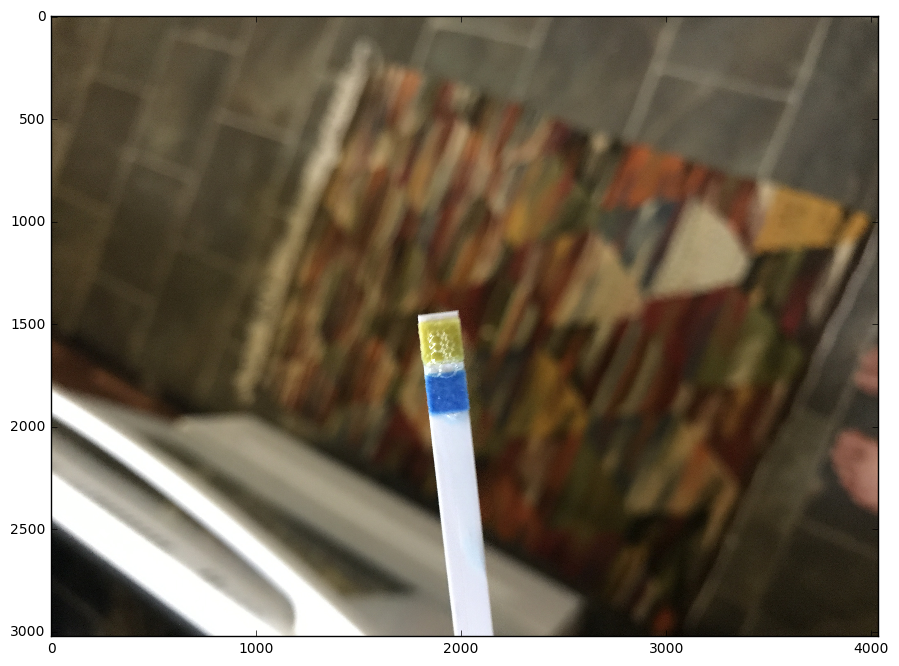

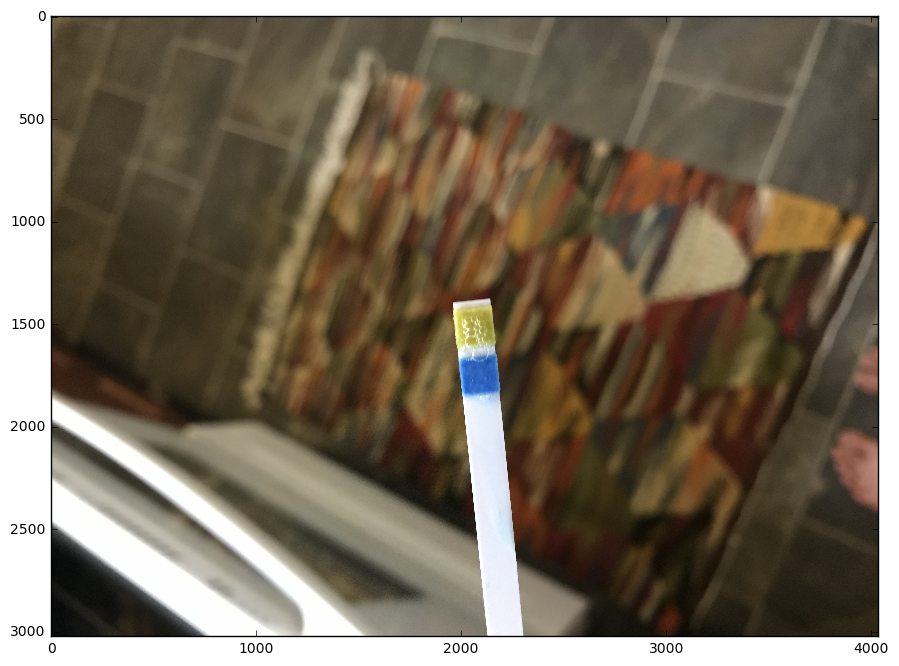

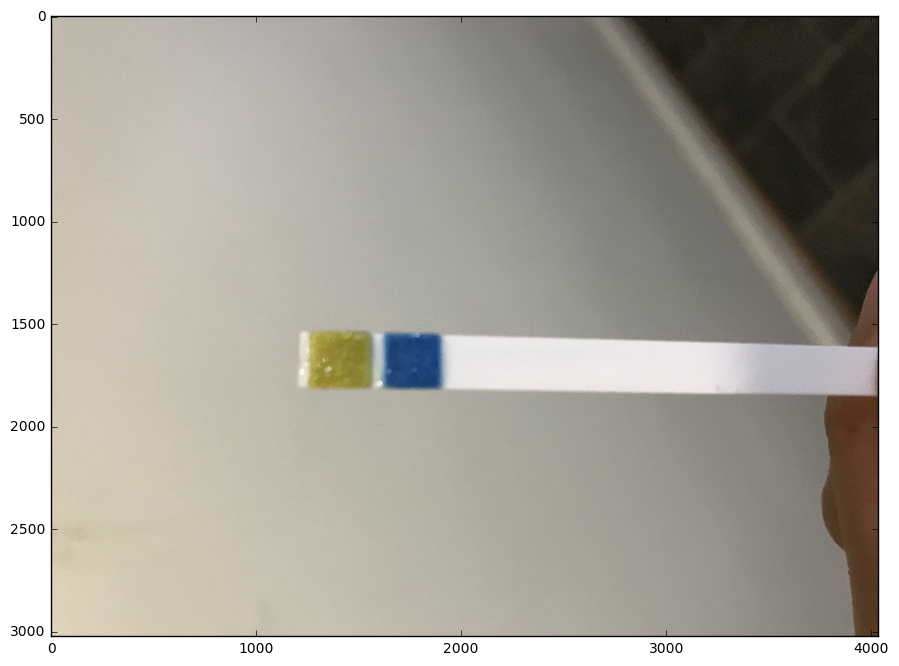

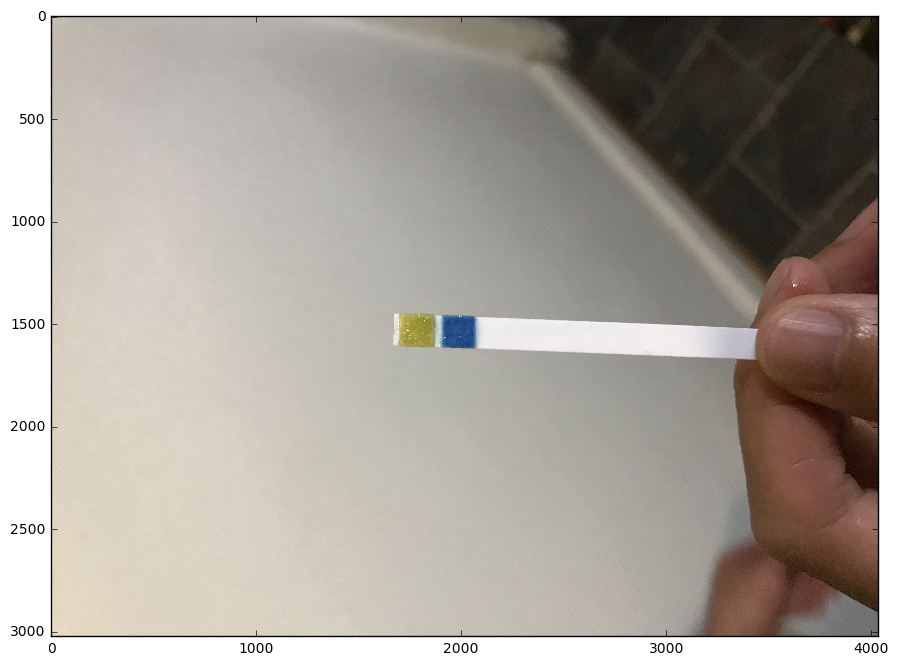

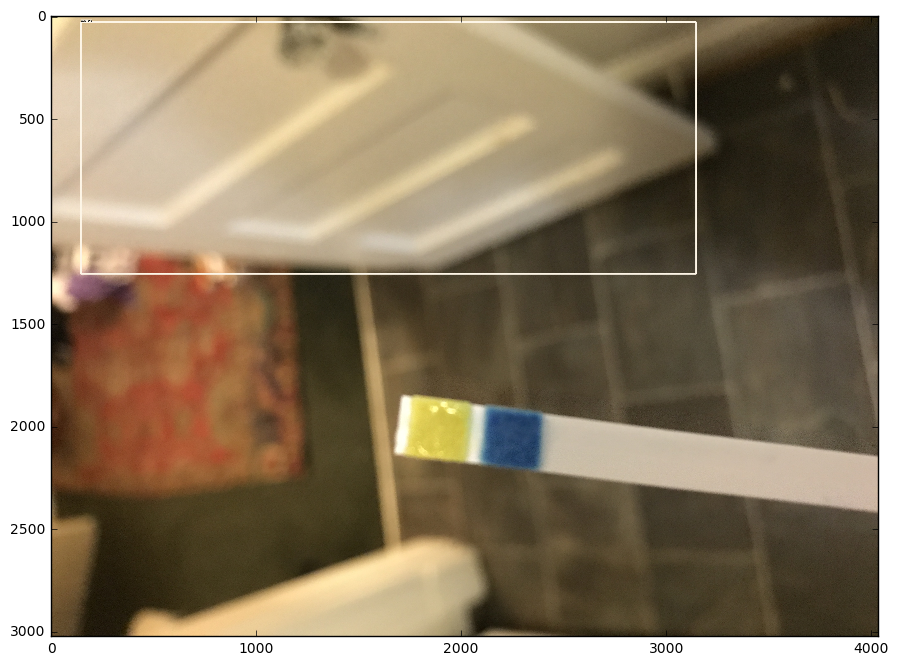

In [32]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    for image_path in TEST_IMAGE_PATHS:
        image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
        image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
        (boxes, scores, classes, num) = sess.run(
            [detection_boxes, detection_scores, detection_classes, num_detections],
            feed_dict={image_tensor: image_np_expanded})
    # Visualization of the results of a detection.
        vis_util.visualize_boxes_and_labels_on_image_array(
            image_np, np.squeeze(boxes), np.squeeze(classes).astype(np.int32),
            np.squeeze(scores), category_index, 
            use_normalized_coordinates=True, line_thickness=8)
        plt.figure(figsize=IMAGE_SIZE)
        plt.imshow(image_np)

To do:
* Create a script to write the json file in the following setup:
```
item {
  id: #
  name: 'test_strip'
}
```
* Create a script to put the annotations in an xml file

In [1]:
#Create a JSON file with the above script setup
import os
file_path = '/Users/robertsonwang/Desktop/bb_images/'
files = [x for x in os.listdir(file_path) if 'jpg' in x or 'JPG' in x ]

In [4]:
def make_label_map(file_path = '/Users/robertsonwang/Desktop/bb_images/raw_input/'):
	files = [x for x in os.listdir(file_path) if 'JPG' in x]

	out_file_str = ''
	for i in range(len(files)):
	    out_file_str += """
	    item {
	    id: %s
	    name: 'test_strip'
	    }
	    """% str(i+1)
	with open(file_path + 'ts_labels_test.txt', 'w') as out_file:
	    out_file.write(out_file_str)

In [5]:
make_label_map()

In [51]:
out_file_str = ''
for i in range(len(files)):
    out_file_str += """
    {
    id: %s
    name: 'test_strip'
    }
    """% str(i+1)
with open(file_path + 'test_strip_labels.txt', 'w') as out_file:
    out_file.write(out_file_str)

In [29]:
import json 

file_path = '/Users/robertsonwang/Desktop/Python/test_strips/'
text_file = 'boundingBoxes4.0-6.0.txt'
with open(file_path + text_file, 'rb') as box_file:
    box_str = box_file.read()

In [37]:
box_list = box_str.replace(':4.0-6.0', '').split('\n')
box_list = [x.split(':') for x in box_list]
image_dict = {k:v for (k, v) in zip([x[0] for x in box_list if x[0] != ''], 
           [eval(x[1]) for x in box_list if x[0] != ''])}

In [67]:
import tensorflow as tf
import sys
sys.path.append('/Users/robertsonwang/Desktop/models/research/')
from object_detection.utils import dataset_util
import json
# flags = tf.app.flags
# flags.DEFINE_string('output_path', '', 'Path to output TFRecord')
# FLAGS = flags.FLAGS

with open('/Users/robertsonwang/Desktop/Python/test_strips/data/bound_results_train.json', 'rb') as data_file:    
    bboxes = json.load(data_file)

def importImage(fileName):
    imgText = open(fileName, 'rb')
    imgTextStr = imgText.read()
    imgText.close()
    return imgTextStr

def create_tf_example(encoded_ts, filename, xmin, xmax, ymin, ymax):
#   Creates a tf proto from sample test_strip image.
#   Args:
#     encoded_ts: The jpg encoded data of the test_strip image.
#   Returns:
#     example: The created tf.Example.

    height = 250
    width = 250
    image_format = b'jpg'

    xmins = [float(xmin)/float(width)]
    xmaxs = [float(xmax)/float(width)]
    ymins = [float(ymin)/float(height)]
    ymaxs = [float(ymax)/float(height)]

    classes_text = ['test_strip']
    classes = [1]

    tf_example = tf.train.Example(features=tf.train.Features(feature={
      'image/height': dataset_util.int64_feature(height),
      'image/width': dataset_util.int64_feature(width),
      'image/filename': dataset_util.bytes_feature(filename),
      'image/source_id': dataset_util.bytes_feature(filename),
      'image/encoded': dataset_util.bytes_feature(encoded_ts),
      'image/format': dataset_util.bytes_feature(image_format),
      'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
      'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
      'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
      'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
      'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
      'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    
    return tf_example

writer = tf.python_io.TFRecordWriter(FLAGS.output_path)

for image in bboxes.keys():
    image = str(image)
    try:
        image_jpg = importImage(image)
    except:
        continue

FailedPreconditionError: 